# Supplementary Material

##  for the paper entitled: "NERO: NEural algorithmic reasoning for zeRO-day attack Detection in the IoT: a hybrid approach

Jesús Cevallos, Alessandra Rizzardi, Sabrina Sicari* and Alberto Coen-Porisini
DISTA- University of Insubria.

*Corresponding author (sabrina.sicari@uninsubria.it)

### Submitted to Computers and Security, under review.
___________________

This notebook creates a synthethic subdivision of the attacks in the "MITM" field of the preprocessed Edgeto IIotset dataset and help visualize the dataset using graphs.

# Imports

In [1]:
# proprietary library for connecting to WandB. (Ignore)
from connect import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jfcevallos. Use `wandb login --relogin` to force relogin


#### Requirements:

hdbscan==0.8.33
umap-pytorch==0.0.7
torch==2.1.0
scikit-learn==1.3.1
pandas==2.1.1
tqdm==4.66.1
numpy==1.24.4
networkx==3.1
matplotlib==3.8.0
plotly==5.17.0

In [2]:
import pandas as pd
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import hdbscan
from umap_pytorch import PUMAP
import torch.nn.functional as F
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the Preprocessed Edge-to-IIotSet:

In [3]:
# The preprocessing followed the authors guidelines on Kaggle:
# https://www.kaggle.com/code/mohamedamineferrag/edge-iiotset-pre-processing

# Get also our version of the dataset, where we created a micro label colummn following the indications of the original paper:
# https://drive.google.com/file/d/1moY1gfWiKSbGTW8G0RVmoWlxcCCZEBTm/view?usp=drive_link
pre_iiotset_path = "YOUR_PATH_TO_PREPROCESSED_EDGE_TO_IIOT_SET"

pre_iiotset_path = "../nfs/jcevallos/datasets/edge-iiot/preprocessed/preprocessed-edge-iiotset.csv"

df = pd.read_csv(
    pre_iiotset_path,
    low_memory=False)

In [4]:
df.groupby(['attack_macro_cat', 'Attack_type']).count()

arp.opcode  arp.hw.size  \
attack_macro_cat      Attack_type                                      
DDoS                  DDoS_HTTP                   48544        48544   
                      DDoS_ICMP                   67939        67939   
                      DDoS_TCP                    50062        50062   
                      DDoS_UDP                   121567       121567   
Information_Gathering Fingerprinting                853          853   
                      Port_Scanning               19977        19977   
                      Vulnerability_scanner       50026        50026   
Injection             SQL_injection               50826        50826   
                      Uploading                   36807        36807   
                      XSS                         15066        15066   
MITM                  MITM                          358          358   
Malware               Backdoor                    24026        24026   
                      Password                    49933        49933   
                      Ransomware                   9689         9689   
Normal                Normal                    1363998      1363998   

                                             icmp.checksum  icmp.seq_le  \
attack_macro_cat      Attack_type                                         
DDoS                  DDoS_HTTP                      48544        48544   
                      DDoS_ICMP                      67939        67939   
                      DDoS_TCP                       50062        50062   
                      DDoS_UDP                      121567       121567   
Information_Gathering Fingerprinting                   853          853   
                      Port_Scanning                  19977        19977   
                      Vulnerability_scanner          50026        50026   
Injection             SQL_injection                  50826        50826   
                      Uploading                      36807        36807   
                      XSS                            15066        15066   
MITM                  MITM                             358          358   
Malware               Backdoor                       24026        24026   
                      Password                       49933        49933   
                      Ransomware                      9689         9689   
Normal                Normal                       1363998      1363998   

                                             icmp.unused  http.content_length  \
attack_macro_cat      Attack_type                                               
DDoS                  DDoS_HTTP                    48544                48544   
                      DDoS_ICMP                    67939                67939   
                      DDoS_TCP                     50062                50062   
                      DDoS_UDP                    121567               121567   
Information_Gathering Fingerprinting                 853                  853   
                      Port_Scanning                19977                19977   
                      Vulnerability_scanner        50026                50026   
Injection             SQL_injection                50826                50826   
                      Uploading                    36807                36807   
                      XSS                          15066                15066   
MITM                  MITM                           358                  358   
Malware               Backdoor                     24026                24026   
                      Password                     49933                49933   
                      Ransomware                    9689                 9689   
Normal                Normal                     1363998              1363998   

                                             http.request.method  \
attack_macro_cat      Attack_type                                  
DDoS                  DDoS_HTT

## Dropping some data
(to resemble a low-training data scenario)

In [5]:
# Step 1: Identify the rows where the "attack" column is equal to "Benign"
benign_rows = df['attack_macro_cat'] == 'Normal'

# Step 2: Calculate the number of rows to keep (1% of the total number of "Benign" rows)
rows_to_keep = int(0.01 * benign_rows.sum())

# Step 3: Randomly select rows to keep (99% of "Benign" rows to delete)
rows_to_delete = df[benign_rows].sample(n=benign_rows.sum() - rows_to_keep, random_state=42).index

# Step 4: Delete the selected rows
df = df.drop(rows_to_delete)

# Optionally, you can reset the index after dropping rows
df = df.reset_index(drop=True)

In [6]:
# Step 1: Identify the rows where the "attack" column is equal to "Benign"
benign_rows = df['Attack_type'] == 'DDoS_UDP'

# Step 2: Calculate the number of rows to keep (1% of the total number of "Benign" rows)
rows_to_keep = int(0.1 * benign_rows.sum())

# Step 3: Randomly select rows to keep (99% of "Benign" rows to delete)
rows_to_delete = df[benign_rows].sample(n=benign_rows.sum() - rows_to_keep, random_state=42).index

# Step 4: Delete the selected rows
df = df.drop(rows_to_delete)

# Optionally, you can reset the index after dropping rows
df = df.reset_index(drop=True)

# Visualize data using graphs:

### Macro Attacks:

In [66]:
def extract_n_rows(group, n=10):
    return group.head(n)


# Group the DataFrame by the "attack_macro_cat" column and apply the function
extracted_df = df.groupby('attack_macro_cat', as_index=False).apply(extract_n_rows)

# Reset the index of the resulting DataFrame
extracted_df.reset_index(drop=True, inplace=True)

In [67]:
# Separate numerical and categorical columns
numerical_cols = extracted_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = extracted_df.select_dtypes(include=['object']).columns

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical columns
        ('cat', OneHotEncoder(), categorical_cols)  # Encode categorical columns
    ])

X_processed = preprocessor.fit_transform(extracted_df)

In [68]:
pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits,
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(X_processed)
embedding = pumap.transform(torch.Tensor(X_processed))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Tue Feb 27 10:50:31 2024 Building RP forest with 5 trees


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | encoder | default_encoder | 96.6 K
--------------------------------------------
96.6 K    Trainable params
0         Non-trainable params
96.6 K    Total params
0.386     Total estimated model params size (MB)


Tue Feb 27 10:50:31 2024 NN descent for 6 iterations
	 1  /  6
	 2  /  6
	 3  /  6
	Stopping threshold met -- exiting after 3 iterations


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([60, 78]) to (60, 2)


In [69]:
macro_labels = extracted_df['attack_macro_cat']

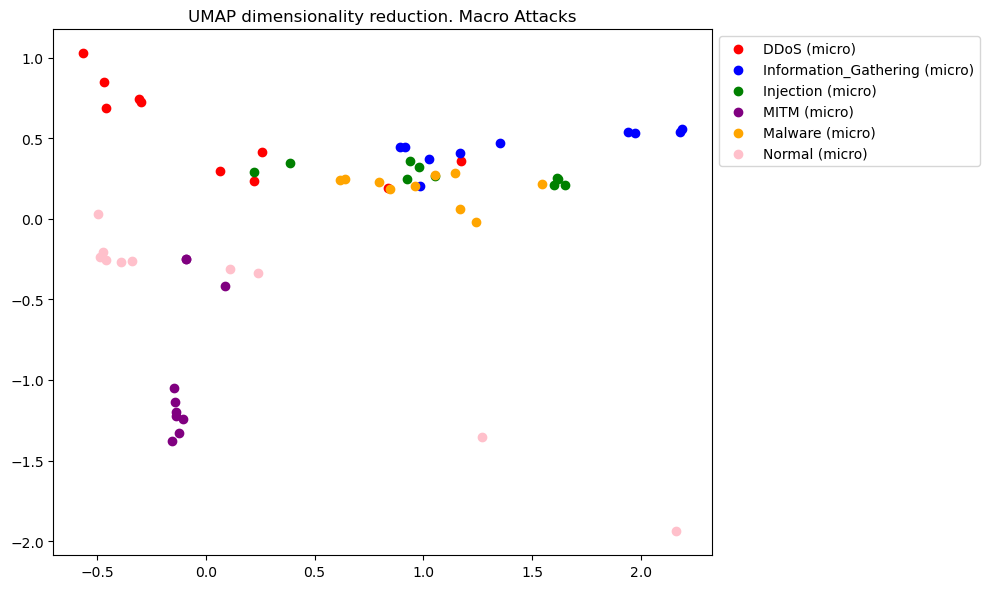

In [70]:
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan',  'brown', 'yellow',
    'olive', 'lime', 'teal', 'maroon', 'navy', 'fuchsia', 'aqua', 'silver', 'sienna'
]

# Create an iterator that cycles through the colors
color_iterator = itertools.cycle(colors)

plt.figure(figsize=(10, 6))

# Two plots:
plt.subplot(1, 1, 1)

# List of attacks:
unique_p_labels = np.unique(macro_labels)

# Print points for each attack
for label in unique_p_labels:
    data = embedding[macro_labels == label]

    label_for_scatter = f'{label} (micro)'
    color_for_scatter = next(color_iterator)

    plt.scatter(
        data[:, 0],
        data[:, 1],
        label=label_for_scatter,
        c=color_for_scatter)

plt.title('UMAP dimensionality reduction. Macro Attacks')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.show()

plt.cla()
plt.close()

In [53]:
embedding_df = pd.DataFrame(embedding)
embedding_df['macro_label'] = macro_labels

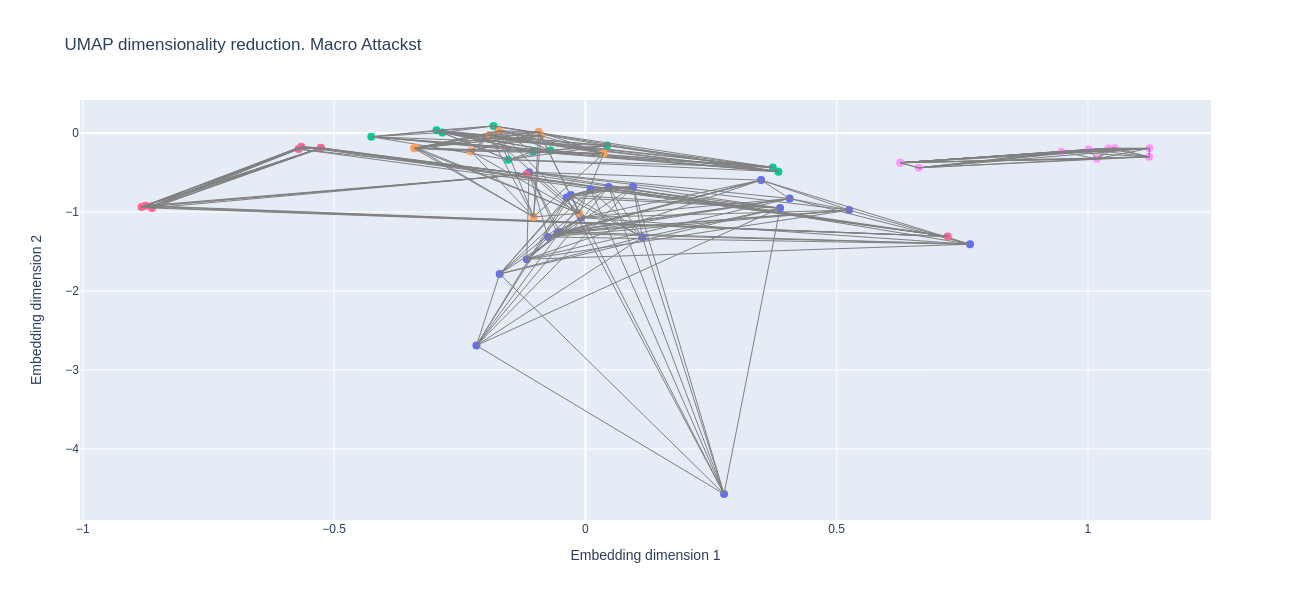

In [71]:
# Create a figure
fig = make_subplots()

# Group by "attack_macro_cat" and iterate through each group
for group_name, group_data in embedding_df.groupby("macro_label"):
    group_data = group_data.reset_index()
    # Add scatter plot for each group
    fig.add_trace(
        go.Scatter(
            x=group_data[0],
            y=group_data[1],
            mode='markers',
            name=str(group_name),
            marker=dict(size=8),
            text=group_data.index  # Show index as hover text
        )
    )

    # Add edges connecting points with the same label
    edges = []
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edges.append(
                go.Scatter(
                    x=[group_data[0][i], group_data[0][j]],
                    y=[group_data[1][i], group_data[1][j]],
                    mode='lines',
                    line=dict(color='gray', width=1),
                    hoverinfo='none'
                )
            )

    fig.add_traces(edges)

# Update layout
fig.update_layout(
    title='UMAP dimensionality reduction. Macro Attackst',
    xaxis=dict(title='Embedding dimension 1'),
    yaxis=dict(title='Embedding dimension 2'),
    showlegend=False,
    height=600,
    width=800
)

# Show the interactive graph
fig.show()

### Micro Attacks:

In [72]:
def extract_n_rows(group, n=5):
    return group.head(n)


# Group the DataFrame by the "attack_macro_cat" column and apply the function
extracted_df = df.groupby('Attack_type', as_index=False).apply(extract_n_rows)

# Reset the index of the resulting DataFrame
extracted_df.reset_index(drop=True, inplace=True)

In [73]:
# Separate numerical and categorical columns
numerical_cols = extracted_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = extracted_df.select_dtypes(include=['object']).columns

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical columns
        ('cat', OneHotEncoder(), categorical_cols)  # Encode categorical columns
    ])

X_processed = preprocessor.fit_transform(extracted_df)

In [74]:
pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits,
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(X_processed)
embedding = pumap.transform(torch.Tensor(X_processed))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Tue Feb 27 10:51:53 2024 Building RP forest with 5 trees
Tue Feb 27 10:51:54 2024 NN descent for 6 iterations
	 1  /  6
	 2  /  6
	 3  /  6
	 4  /  6
	Stopping threshold met -- exiting after 4 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | encoder | default_encoder | 96.6 K
--------------------------------------------
96.6 K    Trainable params
0         Non-trainable params
96.6 K    Total params
0.386     Total estimated model params size (MB)
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning:

The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the traini

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([75, 78]) to (75, 2)


In [75]:
micro_labels = extracted_df['Attack_type']

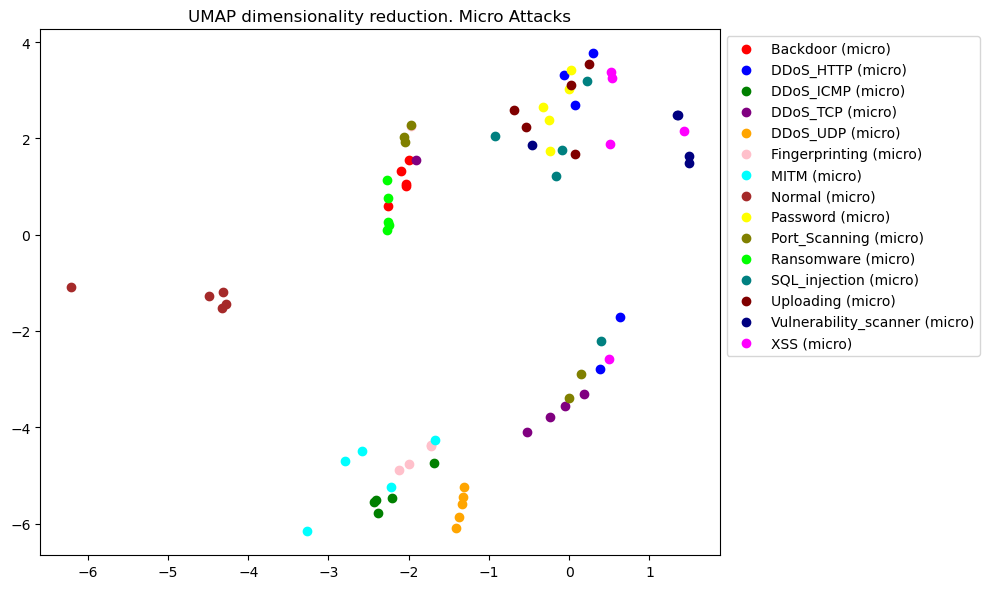

In [78]:
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan',  'brown', 'yellow',
    'olive', 'lime', 'teal', 'maroon', 'navy', 'fuchsia', 'aqua', 'silver', 'sienna'
]

# Create an iterator that cycles through the colors
color_iterator = itertools.cycle(colors)

plt.figure(figsize=(10, 6))

# Two plots:
plt.subplot(1, 1, 1)

# List of attacks:
unique_p_labels = np.unique(micro_labels)

# Print points for each attack
for label in unique_p_labels:
    data = embedding[micro_labels == label]

    label_for_scatter = f'{label} (micro)'
    color_for_scatter = next(color_iterator)

    plt.scatter(
        data[:, 0],
        data[:, 1],
        label=label_for_scatter,
        c=color_for_scatter)

plt.title('UMAP dimensionality reduction. Micro Attacks')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.show()

plt.cla()
plt.close()

In [79]:
embedding_df = pd.DataFrame(embedding)
embedding_df['micro_label'] = micro_labels

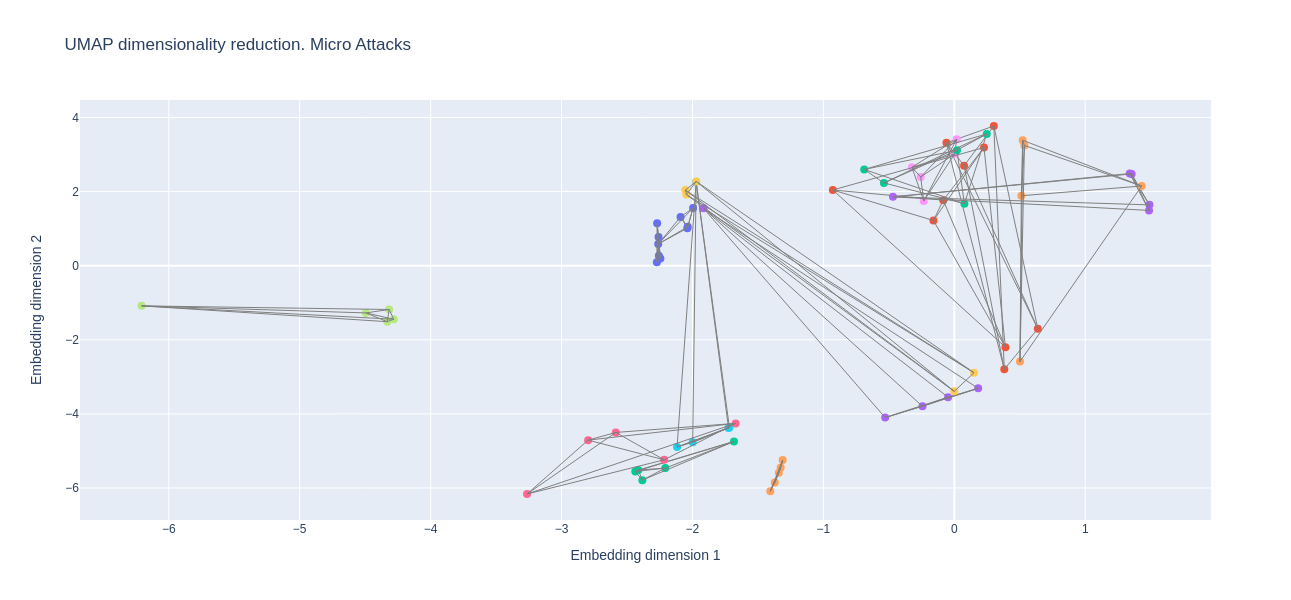

In [82]:
# Create a figure
fig = make_subplots()

# Group by "attack_macro_cat" and iterate through each group
for group_name, group_data in embedding_df.groupby("micro_label"):
    group_data = group_data.reset_index()
    # Add scatter plot for each group
    fig.add_trace(
        go.Scatter(
            x=group_data[0],
            y=group_data[1],
            mode='markers',
            name=str(group_name),
            marker=dict(size=8),
            text=group_data.index  # Show index as hover text
        )
    )

    # Add edges connecting points with the same label
    edges = []
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edges.append(
                go.Scatter(
                    x=[group_data[0][i], group_data[0][j]],
                    y=[group_data[1][i], group_data[1][j]],
                    mode='lines',
                    line=dict(color='gray', width=1),
                    hoverinfo='none'
                )
            )

    fig.add_traces(edges)

# Update layout
fig.update_layout(
    title='UMAP dimensionality reduction. Micro Attacks',
    xaxis=dict(title='Embedding dimension 1'),
    yaxis=dict(title='Embedding dimension 2'),
    showlegend=False,
    height=600,
    width=800
)

# Show the interactive graph
fig.show()

# Creating synthetic micro-clusters:
For the MITM category:

## Dimensionality Reduction:

Let us first reduce the dimensionality of data for DataViz purposes:

In [ ]:
data = df[df['attack_macro_cat']=='MITM'].values
data = data[:,:-3].astype(float)

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits,
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(data)
embedding = pumap.transform(torch.Tensor(data)) # (50000, 2)

## Generating micro clusters:

iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


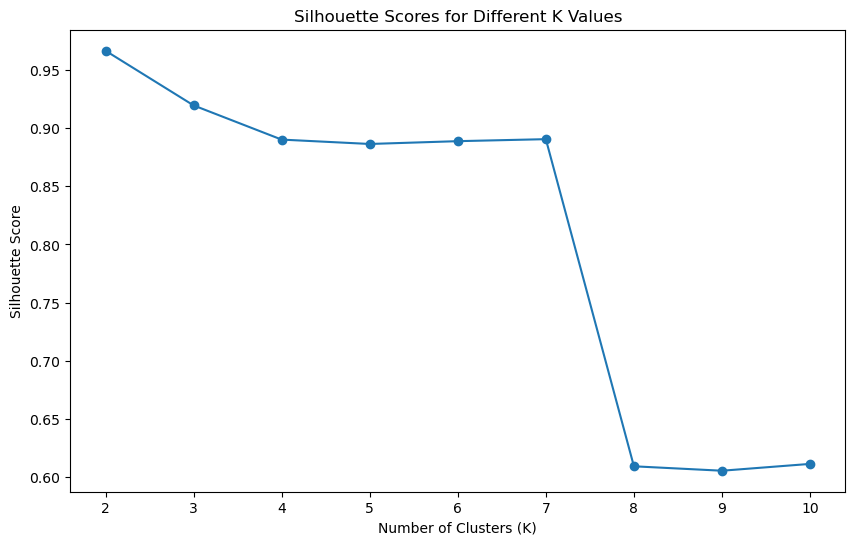

Optimal K: 2


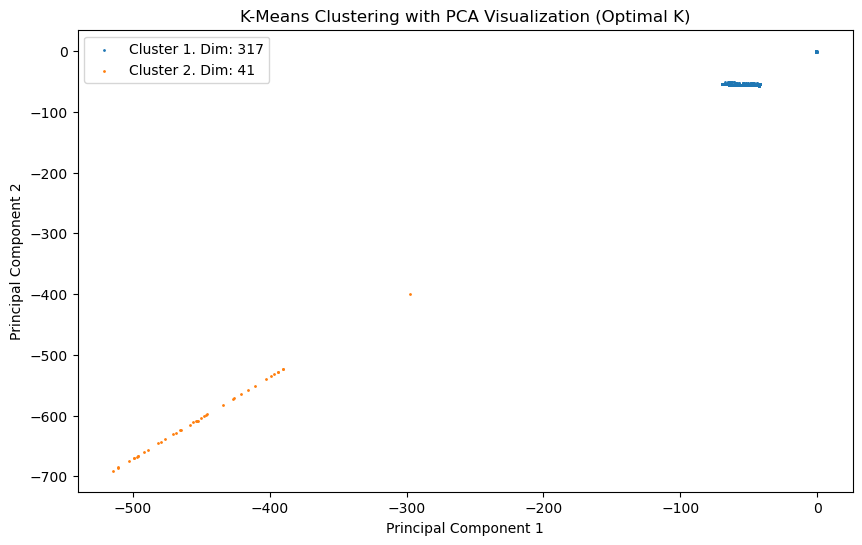

In [49]:
# Specify a range of K values to try
k_values = range(2, 11)

# Store silhouette scores for each K
silhouette_scores = []

# Apply k-means clustering for each K and calculate silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, cluster_labels))
    print(f'iteration {k}')
# Find the optimal K that maximizes the silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]


# Plot the silhouette scores for different K values
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

print(f'Optimal K: {optimal_k}')

# Apply k-means clustering with the optimal K
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
optimal_cluster_labels = optimal_kmeans.fit_predict(data)


# Create a scatter plot of the PCA results colored by optimal cluster labels
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    x_fellas = embedding[optimal_cluster_labels == i, 0]
    y_fellas = embedding[optimal_cluster_labels == i, 1]
    plt.scatter(
        x_fellas,
        y_fellas,
        label=f'Cluster {i + 1}. Dim: {x_fellas.shape[0]}',
        s=1
    )

plt.title('K-Means Clustering with PCA Visualization (Optimal K)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [50]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=31, gen_min_span_tree=True)
clusterer.fit(embedding)
clusterer.labels_.max()

3

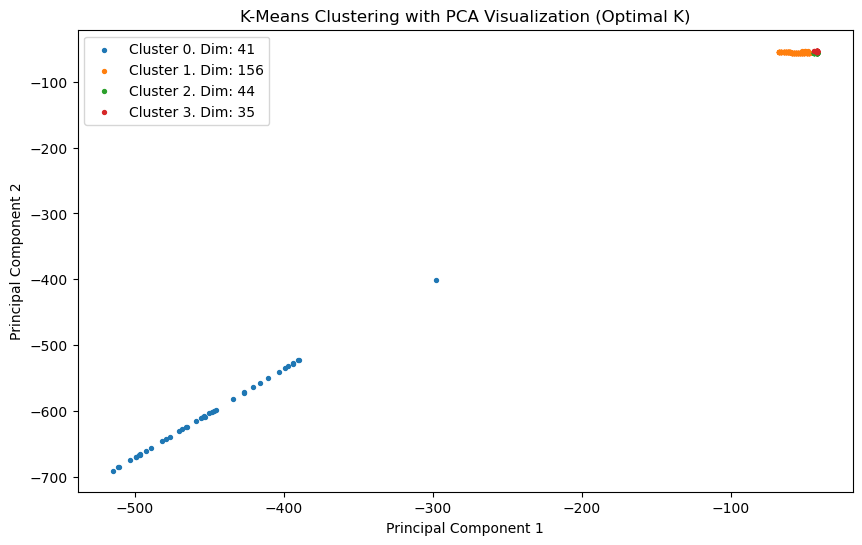

In [51]:
# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Create a scatter plot of the PCA results colored by optimal cluster labels
plt.figure(figsize=(10, 6))
for i in range(0, clusterer.labels_.max()+1):
    x_fellas = embedding[clusterer.labels_ == i, 0]
    y_fellas = embedding[clusterer.labels_ == i, 1]
    plt.scatter(
        x_fellas,
        y_fellas,
        label=f'Cluster {i}. Dim: {x_fellas.shape[0]}',
        s=8
    )

plt.title('K-Means Clustering with PCA Visualization (Optimal K)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Checkpointing:

In [52]:
df.loc[df['attack_macro_cat']=='MITM','Attack_type'] = clusterer.labels_

In [53]:
df.loc[df['attack_macro_cat']=='MITM','Attack_type'] = 'MITM_'+ df.loc[df['attack_macro_cat']=='MITM','Attack_type'].astype(str)

In [ ]:
# UNCOMMENT TO OVERWRITE!
# df.to_csv('pre_processed_iiotset.csv', index=False)